In [1]:
%run stdPackages.ipynb

# Iterative solution

*Set up exogenous parameters:*

In [2]:
m = egm.EGM() # initialize model with default parameters
tIndex = pd.Index(range(2017,2017+m.T+1), name = 'Year') # yearly index
A = m.technologyIndex() # get technology index given parameter values in model 'm'
z = np.zeros(m.T) # exogenous quotas
z[0:41] = np.linspace(2-0.0383*(2017-2013), 0, 41) # zero after 2057
ξPreReform = np.ones(m.T)
ξPostReform = np.ones(m.T)
ξPostReform[1:6] = 2 # double in years 2018-2022
b0, m0 = 1.694, 1.55

Numerical settings:

In [3]:
tol, maxIter = 1e-5, 500

The economic model is solved *given* a set of quoatas:

In [4]:
sol = m.solve(A, z)
sim = m.sim(*sol,A,z,b0)

The EU ETS system can be simulated pre and post-reform, but requires information of $z,b$ to run:

In [5]:
preReform  = egm.ETSSimple(m0,sim[0],z,ξPreReform)
postReform = egm.ETS(m0, sim[0], z, ξPostReform)

### 1: Solve prereform

In [6]:
# %%timeit # This is a benchmarking tool that runs the cell a large number of times to report the average time+std.dev
yi = z # start guess from exogenous quotas
for i in range(maxIter):
    sol = m.solve(A,yi)
    sim = m.sim(*sol, A,yi,b0)
    solETS = egm.ETSSimple(m0, sim[0], z, ξPreReform)
    if sum(np.square(solETS[2]-yi))<tol:
        break
    else:
        yi = solETS[2]

### 2. Solve post reform

In [8]:
# %%timeit # This is a benchmarking tool that runs the cell a large number of times to report the average time+std.dev
yi = z # start guess from exogenous quotas
for i in range(maxIter):
    solPost = m.solve(A,yi)
    simPost = m.sim(*solPost, A,yi,b0)
    solETSPost = egm.ETS(m0, simPost[0], z, ξPostReform)
    if sum(np.square(solETSPost[2]-yi))<tol:
        break
    else:
        yi = solETSPost[2]

### 3. Compare

*Extract dataframes from solution:*

In [9]:
var2int = {'B':0, 'e':1, 'p': 2}
var2intETS = {'M':0, 'NA':1,'y':2}
def dfFromSim(k):
    return pd.DataFrame({'Post-reform': simPost[var2int[k]], 'Pre-reform': sim[var2int[k]]}, index = tIndex[0:len(sim[var2int[k]])])
def dfFromETS(k):
    return pd.DataFrame({'Post-reform': solETSPost[var2intETS[k]], 'Pre-reform': solETS[var2intETS[k]]}, index = tIndex[0:len(solETS[var2intETS[k]])])

Plot main results:

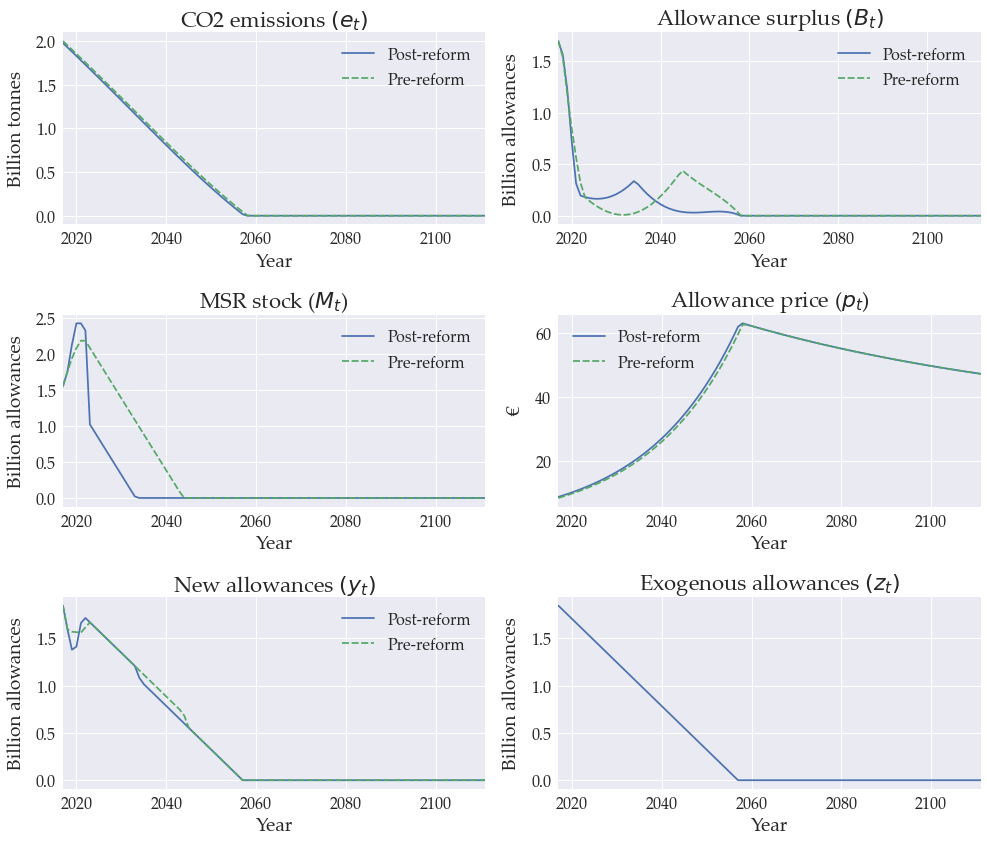

In [10]:
mult_graphs() # use standard settings for one plot with multiple subplots
nplots = 6
nrows = math.ceil(nplots/2)
fig, axes = plt.subplots(nrows, min(nplots, 2), figsize = (14, (4*nrows)));
plt.subplots_adjust(hspace=0.35)
# Plot 1: Emissions
ax = plt.subplot(nrows, min(nplots,2), 1)
df = dfFromSim('e');
seaborn.lineplot(data=df, ax = ax)
ax.set_ylabel("Billion tonnes", labelpad=10);
ax.set_title('CO2 emissions $(e_t)$');
ax.set_xlim([df.index[0], df.index[-1]])

# Plot 2: Emission surplus (B):
ax = plt.subplot(nrows, min(nplots,2), 2)
df = dfFromSim('B');
seaborn.lineplot(data=df, ax = ax)
ax.set_ylabel("Billion allowances", labelpad=10);
ax.set_title('Allowance surplus $(B_t)$');
ax.set_xlim([df.index[0], df.index[-1]])

# Plot 3: MSR stock (M):
ax = plt.subplot(nrows, min(nplots,2), 3)
df = dfFromETS('M');
seaborn.lineplot(data=df, ax = ax)
ax.set_ylabel("Billion allowances", labelpad=10);
ax.set_title('MSR stock ($M_t$)');
ax.set_xlim([df.index[0], df.index[-1]])

# Plot 4: Allowance price (p):
ax = plt.subplot(nrows, min(nplots,2), 4)
df = dfFromSim('p');
seaborn.lineplot(data=df, ax = ax)
ax.set_ylabel("€", labelpad=10);
ax.set_title('Allowance price ($p_t$)');
ax.set_xlim([df.index[0], df.index[-1]])

# Plot 5: New allocanes (y):
ax = plt.subplot(nrows, min(nplots,2), 5)
df = dfFromETS('y');
seaborn.lineplot(data=df, ax = ax)
ax.set_ylabel("Billion allowances", labelpad=10);
ax.set_title('New allowances $(y_t)$');
ax.set_xlim([df.index[0], df.index[-1]])

# Plot 6: Exogenous path of allowances (z):
ax = plt.subplot(nrows, min(nplots,2), 6)
seaborn.lineplot(data=pd.Series(z, index = tIndex[0:len(z)]), ax = ax)
ax.set_ylabel("Billion allowances", labelpad=10);
ax.set_title('Exogenous allowances $(z_t)$');
ax.set_xlim([df.index[0], df.index[-1]])
fig.tight_layout()